In [96]:
import os, sys
import glob
import numpy as np
import pandas as pd
import joblib

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

In [97]:
def binning(bin_var, bin_min, bin_max, n_bin):
    bin_xs = np.concatenate(([-np.inf], np.linspace(bin_min, bin_max, n_bin + 1), [np.inf]), axis=0)
    bin_step = bin_xs[2] - bin_xs[1]
    bin_centers = []
    for i in range(1, len(bin_xs) - 2):
        bin_centers.append((bin_xs[i] + bin_xs[i+1]) / 2)
    bin_centers = np.concatenate(([bin_centers[0] - bin_step], bin_centers, [bin_centers[-1] + bin_step]), axis=0)
    
    bin_indices = np.digitize(bin_var, bin_xs) - 1
    bin_masks = [(bin_indices == i) for i in range(len(bin_xs) - 1)]
    return bin_xs, bin_centers, bin_masks


def plot_n_matches(
    var, var_min, var_max, n_bin,
    xlabel, ylabel, title,
    output_path,
):
    bin_xs, bin_centers, bin_masks = binning(var, var_min, var_max, n_bin)
    bin_step = bin_xs[2] - bin_xs[1]
    mean_n_Y = []
    mean_n_Y_pred = []

    for bin_mask in bin_masks:
        mean_n_Y.append(n_Y[bin_mask].mean())
        mean_n_Y_pred.append(n_Y_pred[bin_mask].mean())

    plt.figure(figsize=(8, 5))
    plt.bar(
        bin_centers,
        mean_n_Y_pred,
        width=bin_step,
        label=r'$N\ Matches_{Predict}$',
        edgecolor='black',
        linewidth=1.0,
        hatch='\\',
        alpha=0.6
    )

    plt.bar(
        bin_centers,
        mean_n_Y,
        width=bin_step,
        label=r'$N\ Matches_{Data}$',
        edgecolor='black',
        linewidth=1.0,
        hatch='/',
        alpha=0.6
    )

    plt.xlim(bin_centers[1] - bin_step, bin_centers[-2] + bin_step)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.legend()
    plt.savefig(output_path)


def plot_n_false_matches(
    var, var_min, var_max, n_bin,
    xlabel, ylabel, title,
    output_path,    
):
    bin_xs, bin_centers, bin_masks = binning(var, var_min, var_max, n_bin)
    bin_step = bin_xs[2] - bin_xs[1]

    mean_n_only_data, mean_n_only_pred = [], []
    
    for bin_mask in bin_masks:
        mean_n_only_data.append(n_only_data[bin_mask].mean())
        mean_n_only_pred.append(n_only_pred[bin_mask].mean())
    
    plt.figure(figsize=(8, 5))
    
    plt.bar(
        bin_centers,
        mean_n_only_data,
        bottom=mean_n_only_pred,
        width=bin_step,
        alpha=0.6,
        label='Missed Detector',
        edgecolor='black',
        linewidth=1.0,
        hatch='/',
    )
    
    plt.bar(
        bin_centers,
        mean_n_only_pred,
        width=bin_step,
        alpha=0.6,
        label='False Predict Detector',
        edgecolor='black',
        linewidth=1.0,
        hatch='\\',
    )

    plt.xlim(bin_centers[1] - bin_step, bin_centers[-2] + bin_step)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    plt.legend()
    plt.savefig(output_path)


def plot_ratio_matches(
    var, var_min, var_max, n_bin,
    xlabel, ylabel, title,
    output_path,
):
    bin_xs, bin_centers, bin_masks = binning(var, var_min, var_max, n_bin)
    bin_step = bin_xs[2] - bin_xs[1]
    
    no_diff_ratio, data_in_pred_ratio = [], []
    for bin_mask in bin_masks:
        unique, count = np.unique(n_diff[bin_mask], return_counts=True)
        no_diff_ratio.append(count[0] / count.sum() if len(count) != 0 else 0)

        unique, count = np.unique(n_only_data[bin_mask], return_counts=True)
        data_in_pred_ratio.append(count[0] / count.sum() if len(count) != 0 else 0)

    plt.figure(figsize=(8, 5))

    plt.bar(
        bin_centers,
        data_in_pred_ratio,
        width=bin_step,
        alpha=0.6,
        label=r'$Det_{Data} \subset Det_{Predict}$',
        edgecolor='black',
        linewidth=1.0,
        hatch='/',
    )

    plt.bar(
        bin_centers,
        no_diff_ratio,
        width=bin_step,
        alpha=0.6,
        label=r'$Det_{Data} = Det_{Predict}$',
        edgecolor='black',
        linewidth=1.0,
        hatch='\\',
    )

    plt.xlim(bin_centers[1] - bin_step, bin_centers[-2] + bin_step)
    plt.ylim(0, 1.0)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.legend()
    plt.savefig(output_path)

In [98]:
data_dir = '/users/hep/eigen1907/STORE/TrackDetMatches'
detid_table_path = '/users/hep/eigen1907/Workspace/Workspace-DL/241222-det_raw_id/matched_det_raw_id.csv'
input_model_dir = '/users/hep/eigen1907/Workspace/Workspace-DL/241222-XGBoost/model/file300-e100-d5-lr0.1'

model = XGBClassifier()
model.load_model(os.path.join(input_model_dir, 'model.json'))
track_scaler = joblib.load(os.path.join(input_model_dir, 'scaler.pkl'))
detid_encoder = joblib.load(os.path.join(input_model_dir, 'encoder.pkl'))

eval_paths = sorted(glob.glob(os.path.join(data_dir, '*.csv')))[-100:]
df_list = [pd.read_csv(eval_path) for eval_path in eval_paths]
df = pd.concat(df_list, ignore_index=True)

df['match_raw_id'] = df['match_raw_id'].apply(lambda x: list(map(int, str(x).split(' ')[:-1])))
df['assos_raw_id'] = df['assos_raw_id'].apply(lambda x: list(map(int, str(x).split(' ')[:-1])))
df['candi_raw_id'] = df['candi_raw_id'].apply(lambda x: list(map(int, str(x).split(' ')[:-1])))

track_info = df[['track_pt', 'track_eta', 'track_phi']].values
track_pt = track_info[:, 0]
track_eta = track_info[:, 1]
track_phi = track_info[:, 2]

X = track_scaler.transform(track_info)
Y = detid_encoder.transform(df['match_raw_id'])

Y_cmssw = detid_encoder.transform(df['candi_raw_id'])

Y_pred_proba = model.predict_proba(X)
thresholds = [0.5, 0.1, 0.01, 0.001]
Y_preds = [(Y_pred_proba > threshold).astype(int) for threshold in thresholds]

In [99]:
detid_table = pd.read_csv(detid_table_path, index_col=False)
detid_table_noGEM = detid_table[detid_table['sub_det'] != 'GEM']
print(detid_table_noGEM) ## 3614

      det_raw_id sub_det  det_raw_id_match
0      574914560      DT              True
1      574947328      DT              True
2      574980096      DT              True
3      575012864      DT              True
4      575045632      DT              True
...          ...     ...               ...
3609   637653706     RPC              True
3610   637653732     RPC              True
3611   637653734     RPC              True
3612   637653736     RPC              True
3613   637653738     RPC              True

[3614 rows x 3 columns]


In [100]:
output_dir = f'/users/hep/eigen1907/Workspace/Workspace-DL/250106-plotting/plots-bin{n_bin}'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [1]:
fig, ax = plt.subplots(figsize=(12, 8))

n_Y = Y[:, :3614].sum(axis=1)
n_Y_cmssw = Y_cmssw[:, :3614].sum(axis=1)
n_Y_preds = [Y_pred[:, :3614].sum(axis=1) for Y_pred in Y_preds]

n_bin = 10

bin_xs, bin_centers, bin_masks = binning(track_pt, 0, 1000, n_bin)
bin_step = bin_xs[2] - bin_xs[1]

mean_n_Y = [n_Y[bin_mask].mean() for bin_mask in bin_masks]
mean_n_Y_cmssw = [n_Y_cmssw[bin_mask].mean() for bin_mask in bin_masks]
mean_n_Y_preds = []
for n_Y_pred in n_Y_preds:
    mean_n_Y_preds.append([n_Y_pred[bin_mask].mean() for bin_mask in bin_masks])


plt.step(
    bin_centers,
    mean_n_Y,
    label='Matched Detector'
)

plt.step(
    bin_centers,
    mean_n_Y_cmssw,
    label='Candidate Detector from CMSSW',
)

for idx in range(len(mean_n_Y_preds)):
    plt.step(
        bin_centers,
        mean_n_Y_preds[idx],
        label=f'Candidate Detector from BDT (threshold > {thresholds[idx]})'
    )

plt.xlim(bin_centers[1], bin_centers[-2])
plt.xlabel(r'$p_T$')
plt.ylabel(f'<Number of Detectors>')
#plt.title(f)
plt.legend()
plt.savefig(output_dir + '/n_detector.png')

# All inputs for next step(current algorithm)

NameError: name 'plt' is not defined

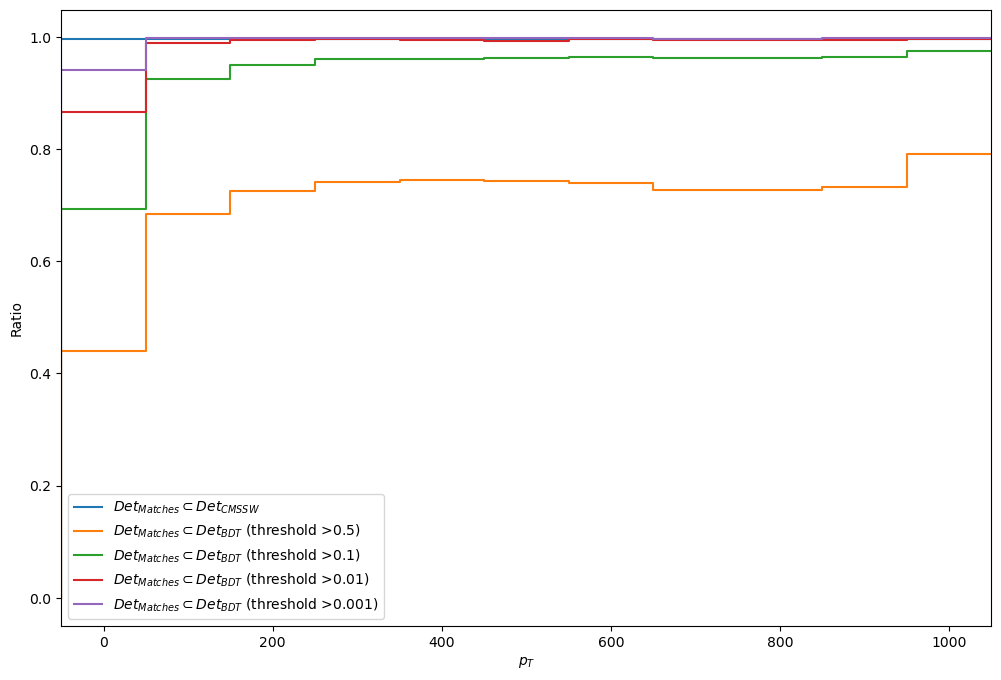

In [107]:
fig, ax = plt.subplots(figsize=(12, 8))

n_bin = 10

bin_xs, bin_centers, bin_masks = binning(track_pt, 0, 1000, n_bin)
bin_step = bin_xs[2] - bin_xs[1]

ratio_match_in_candi_cmssw = []
for bin_mask in bin_masks:
    n_only_data = (Y[:, :3614] > Y_cmssw[:, :3614]).sum(axis=1)[bin_mask]
    ratio_match_in_candi_cmssw.append(np.count_nonzero(n_only_data == 0) / len(n_only_data) if len(n_only_data) != 0 else 0)
plt.step(
    bin_centers,
    ratio_match_in_candi_cmssw,
    label=r'$Det_{Matches} \subset Det_{CMSSW}$'
)


ratio_match_in_candi_preds = []
for Y_pred in Y_preds:
    ratio_match_in_candi_pred = []
    for bin_mask in bin_masks:
        n_only_data = (Y[:, :3614] > Y_pred[:, :3614]).sum(axis=1)[bin_mask]
        ratio_match_in_candi_pred.append(np.count_nonzero(n_only_data == 0) / len(n_only_data) if len(n_only_data) != 0 else 0)
    ratio_match_in_candi_preds.append(ratio_match_in_candi_pred)

for idx in range(len(ratio_match_in_candi_preds)):
    plt.step(
        bin_centers,
        ratio_match_in_candi_preds[idx],
        label=r'$Det_{Matches} \subset Det_{BDT}$'+ f' (threshold >{thresholds[idx]})'
    )

plt.xlim(bin_centers[1] - bin_step, bin_centers[-2] + bin_step)
plt.xlabel(r'$p_T$')
plt.ylabel(f'Ratio')
#plt.title(f)
plt.legend()
plt.savefig(output_dir + '/ratio_detector.png')

In [ ]:
track_(Det_Matches in Det_CMSSW) / track_all

In [103]:
data_only = Y > Y_cmssw